In [0]:
'''
Training and saving models
'''

In [5]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive/') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import os
import time
from matplotlib import pyplot

In [0]:
# Configs
data_folder = "/content/drive/My Drive/TensorSMC/check_char_lstm/data/"
train_dataset = data_folder + "training_dataset/nietzsche.txt"
output_folder_models = data_folder + "trained_models/"

In [0]:
# Main functions

def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot
  
def get_batches(arr, batch_size, seq_length):
  '''Create a generator that returns batches of size
     batch_size x seq_length from arr.

     Arguments
     ---------
     arr: Array you want to make batches from
     batch_size: Batch size, the number of sequences per batch
     seq_length: Number of encoded chars in a sequence
  '''

  batch_size_total = batch_size * seq_length
  # total number of batches we can make, // integer division, round down
  n_batches = len(arr)//batch_size_total

  # Keep only enough characters to make full batches
  arr = arr[:n_batches * batch_size_total]
  # Reshape into batch_size rows, n. of first row is the batch size, the other lenght is inferred
  arr = arr.reshape((batch_size, -1))

  # iterate through the array, one sequence at a time
  for n in range(0, arr.shape[1], seq_length):
      # The features
      x = arr[:, n:n+seq_length]
      # The targets, shifted by one
      y = np.zeros_like(x)
      try:
          y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
      except IndexError:
          y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
      yield x, y 

#when we call get batches we are going 
#to create a generator that iteratest through our array and returns x, y with yield command

In [0]:
class CharRNN(nn.Module):
    
    def __init__(self, tokens, n_hidden=612, n_layers=4,
                               drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        # creating character dictionaries
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        ## TODO: define the LSTM
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        ## TODO: define a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## TODO: define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, len(self.chars))
      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
                
        ## TODO: Get the outputs and the new hidden state from the lstm
        r_output, hidden = self.lstm(x, hidden)
        
        ## TODO: pass through a dropout layer
        out = self.dropout(r_output)
        
        # Stack up LSTM outputs using view
        # you may need to use contiguous to reshape the output
        out = out.contiguous().view(-1, self.n_hidden)
        
        ## TODO: put x through the fully-connected layer
        out = self.fc(out)
        
        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden
      
      
def train(net, data, epochs=10, batch_size=10, seq_length=50, lr=0.001, clip=5, val_frac=0.1, print_every=10):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        seq_length: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        print_every: Number of steps for printing training and validation loss
    
    '''
    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    if(train_on_gpu):
        net.cuda()
    
    counter = 0
    n_chars = len(net.chars)
    for e in range(epochs):
        # initialize hidden state
        h = net.init_hidden(batch_size)
        
        for x, y in get_batches(data, batch_size, seq_length):
            counter += 1
            
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            if(train_on_gpu):
                inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()
            
            # get the output from the model
            output, h = net(inputs, h)
            
            # calculate the loss and perform backprop
            loss = criterion(output, targets.view(batch_size*seq_length))
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
            
            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                for x, y in get_batches(val_data, batch_size, seq_length):
                    # One-hot encode our data and make them Torch tensors
                    x = one_hot_encode(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])
                    
                    inputs, targets = x, y
                    if(train_on_gpu):
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, targets.view(batch_size*seq_length))
                
                    val_losses.append(val_loss.item())
                
                net.train() # reset to train mode after iterationg through validation data
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))
                
                hist_val_loss.append(np.mean(val_losses))
                hist_loss.append(loss.item())

In [15]:
# Data preparation
f = open(train_dataset, 'r')
content = f.read()
import re
s = re.sub('--', ' ', content)
s = re.sub(r'[^\w\s\,\.]','',s)
s = re.sub('\n', ' ', s)

s = str.lower(s)
content = s

content_size = len(content)
print('content_size = {}'.format(content_size))
print('Example of content: {}'.format(content[0:1000]))

test_seq = np.array([[3, 5, 1]])
one_hot = one_hot_encode(test_seq, 8)

print(one_hot)

text = content

# encode the text and map each character to an integer and vice versa

# we create two dictionaries:
# 1. int2char, which maps integers to characters
# 2. char2int, which maps characters to unique integers
chars = tuple(set(text))
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}

# encode the text
encoded = np.array([char2int[ch] for ch in text])


batches = get_batches(encoded, 8, 50)
x, y = next(batches)

content_size = 593218
Example of content: preface   supposing that truth is a woman what then is there not ground for suspecting that all philosophers, in so far as they have been dogmatists, have failed to understand women that the terrible seriousness and clumsy importunity with which they have usually paid their addresses to truth, have been unskilled and unseemly methods for winning a woman certainly she has never allowed herself to be won and at present every kind of dogma stands with sad and discouraged mien if, indeed, it stands at all for there are scoffers who maintain that it has fallen, that all dogma lies on the ground nay more, that it is at its last gasp. but to speak seriously, there are good grounds for hoping that all dogmatizing in philosophy, whatever solemn, whatever conclusive and decided airs it has assumed, may have been only a noble puerilism and tyronism and probably the time is at hand when it will be once and again understood what has actually sufficed for th

In [16]:
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')


Training on GPU!


In [0]:
# Model Training parameters

n_hidden_list = [124, 512, 1024]
n_layers_list = [1,4]
seq_length_list = [80, 160]

********** model_124_1_80_50 ************


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


CharRNN(
  (lstm): LSTM(41, 124, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=124, out_features=41, bias=True)
)
Epoch: 1/50... Step: 50... Loss: 2.9128... Val Loss: 2.8876
Epoch: 1/50... Step: 100... Loss: 2.8626... Val Loss: 2.8310
Epoch: 2/50... Step: 150... Loss: 2.7103... Val Loss: 2.6811
Epoch: 2/50... Step: 200... Loss: 2.5596... Val Loss: 2.5152
Epoch: 3/50... Step: 250... Loss: 2.4527... Val Loss: 2.4051
Epoch: 3/50... Step: 300... Loss: 2.3983... Val Loss: 2.3377
Epoch: 4/50... Step: 350... Loss: 2.3535... Val Loss: 2.2895
Epoch: 4/50... Step: 400... Loss: 2.3065... Val Loss: 2.2488
Epoch: 5/50... Step: 450... Loss: 2.3032... Val Loss: 2.2159
Epoch: 5/50... Step: 500... Loss: 2.2620... Val Loss: 2.1888
Epoch: 6/50... Step: 550... Loss: 2.2199... Val Loss: 2.1664
Epoch: 6/50... Step: 600... Loss: 2.2160... Val Loss: 2.1414
Epoch: 7/50... Step: 650... Loss: 2.1788... Val Loss: 2.1194
Epoch: 7/50... Step: 700... Loss: 2.2091... Val Loss: 

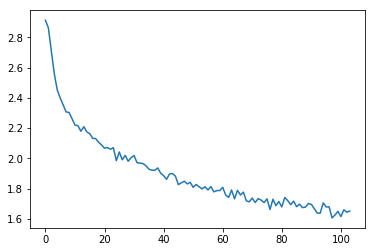

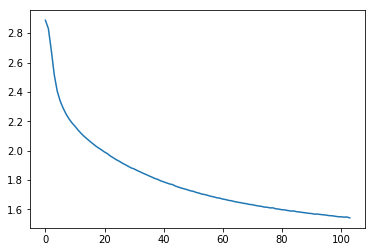

********** model_124_1_160_50 ************
CharRNN(
  (lstm): LSTM(41, 124, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=124, out_features=41, bias=True)
)
Epoch: 1/50... Step: 50... Loss: 2.9242... Val Loss: 2.8880
Epoch: 2/50... Step: 100... Loss: 2.8657... Val Loss: 2.8391
Epoch: 3/50... Step: 150... Loss: 2.7284... Val Loss: 2.6905
Epoch: 4/50... Step: 200... Loss: 2.5766... Val Loss: 2.5188
Epoch: 5/50... Step: 250... Loss: 2.4538... Val Loss: 2.4041
Epoch: 6/50... Step: 300... Loss: 2.3831... Val Loss: 2.3317
Epoch: 7/50... Step: 350... Loss: 2.3601... Val Loss: 2.2813
Epoch: 8/50... Step: 400... Loss: 2.2685... Val Loss: 2.2400
Epoch: 9/50... Step: 450... Loss: 2.2551... Val Loss: 2.2066
Epoch: 10/50... Step: 500... Loss: 2.2181... Val Loss: 2.1744
Epoch: 11/50... Step: 550... Loss: 2.2129... Val Loss: 2.1516
Epoch: 12/50... Step: 600... Loss: 2.2152... Val Loss: 2.1215
Epoch: 13/50... Step: 650... Loss: 2.1519... Val Loss: 2.0993
Epoch: 

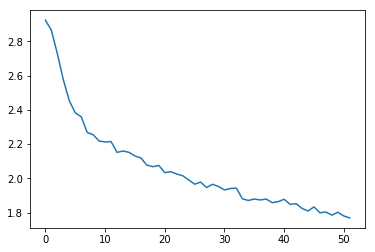

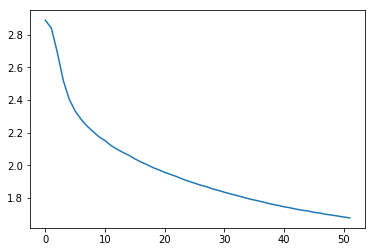

********** model_124_4_80_50 ************
CharRNN(
  (lstm): LSTM(41, 124, num_layers=4, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=124, out_features=41, bias=True)
)
Epoch: 1/50... Step: 50... Loss: 2.9314... Val Loss: 2.8977
Epoch: 1/50... Step: 100... Loss: 2.9110... Val Loss: 2.8924
Epoch: 2/50... Step: 150... Loss: 2.9138... Val Loss: 2.8919
Epoch: 2/50... Step: 200... Loss: 2.9100... Val Loss: 2.8897
Epoch: 3/50... Step: 250... Loss: 2.9079... Val Loss: 2.8901
Epoch: 3/50... Step: 300... Loss: 2.9022... Val Loss: 2.8891
Epoch: 4/50... Step: 350... Loss: 2.9092... Val Loss: 2.8892
Epoch: 4/50... Step: 400... Loss: 2.9076... Val Loss: 2.8869
Epoch: 5/50... Step: 450... Loss: 2.7828... Val Loss: 2.7138
Epoch: 5/50... Step: 500... Loss: 2.6665... Val Loss: 2.6182
Epoch: 6/50... Step: 550... Loss: 2.5797... Val Loss: 2.5190
Epoch: 6/50... Step: 600... Loss: 2.4866... Val Loss: 2.4293
Epoch: 7/50... Step: 650... Loss: 2.4286... Val Loss: 2.373

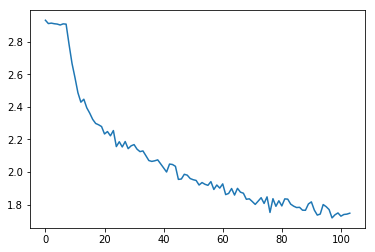

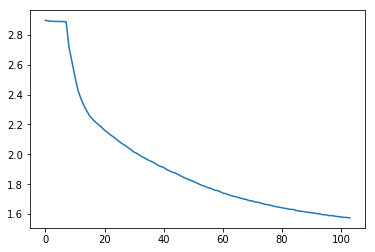

********** model_124_4_160_50 ************
CharRNN(
  (lstm): LSTM(41, 124, num_layers=4, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=124, out_features=41, bias=True)
)
Epoch: 1/50... Step: 50... Loss: 2.9380... Val Loss: 2.8976
Epoch: 2/50... Step: 100... Loss: 2.9168... Val Loss: 2.8929
Epoch: 3/50... Step: 150... Loss: 2.9156... Val Loss: 2.8910
Epoch: 4/50... Step: 200... Loss: 2.9124... Val Loss: 2.8902
Epoch: 5/50... Step: 250... Loss: 2.8999... Val Loss: 2.8899
Epoch: 6/50... Step: 300... Loss: 2.9031... Val Loss: 2.8898
Epoch: 7/50... Step: 350... Loss: 2.9132... Val Loss: 2.8900
Epoch: 8/50... Step: 400... Loss: 2.9103... Val Loss: 2.8900


In [0]:
# Model parameters
# n_hidden=512
# n_layers=4

batch_size = 64
# seq_length = 160 # max length of sequence
n_epochs = 50 

for n_hidden in n_hidden_list:
  for n_layers in n_layers_list:
    for seq_length in seq_length_list:
      model_name = "model_{}_{}_{}_{}".format(n_hidden, n_layers, seq_length, n_epochs)
      print("********** {} ************".format(model_name))
      hist_loss = []
      hist_val_loss = []

      net = CharRNN(chars, n_hidden, n_layers)
      print(net)
      # train the model
      train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=50)
      
      pyplot.plot(hist_loss)
      pyplot.show()

      pyplot.plot(hist_val_loss)
      pyplot.show()
      
      checkpoint = {'n_hidden': net.n_hidden,
              'n_layers': net.n_layers,
              'state_dict': net.state_dict(),
              'tokens': net.chars}

      with open(output_folder_models+model_name, 'wb') as f:
          torch.save(checkpoint, f)

# Appendix

In [0]:
def predict(net, char, h=None, top_k=None):
        ''' Given a character, predict the next character.
            Returns the predicted character and the hidden state.
        '''
        
        # tensor inputs
        x = np.array([[net.char2int[char]]])
        x = one_hot_encode(x, len(net.chars))
        inputs = torch.from_numpy(x)
        
        if(train_on_gpu):
            inputs = inputs.cuda()
        
        # detach hidden state from history
        h = tuple([each.data for each in h])
        # get the output of the model
        out, h = net(inputs, h)

        # get the character probabilities
        # apply softmax to get p probabilities for the likely next character giving x
        p = F.softmax(out, dim=1).data
        if(train_on_gpu):
            p = p.cpu() # move to cpu
        
        
        # keep probability to use later
        prob = p.numpy().squeeze()
        char_index = np.argmax(prob)
        char_pred = net.int2char[char_index]
        prob_pred = prob[char_index]
        
#         # get top characters
#         # considering the k most probable characters with topk method
#         if top_k is None:
#             top_ch = np.arange(len(net.chars))
#         else:
#             p, top_ch = p.topk(top_k)
#             top_ch = top_ch.numpy().squeeze()
        
        
#         # select the likely next character with some element of randomness
#         p = p.numpy().squeeze()
#         char = np.random.choice(top_ch, p=p/p.sum())
        
#         # return the encoded value of the predicted char and the hidden state
#        return net.int2char[char], h, prob
        return char_pred, h, prob_pred

In [0]:
t1 = time.time()
prime = 'but to speak seriou' # But to speak seriously
# print('length of prime = {}'.format(len(prime)))

chars = [ch for ch in prime]
h = net.init_hidden(1)
for ch in prime:
  char, h, prob = predict(net, ch, h)
  print("ch = {}, char = {}, prob = {}".format(ch, char, prob))

print("time taken to predict: {}".format(time.time()-t1))
  
  

ch = b, char = e, prob = 0.30611371994018555
ch = u, char = l, prob = 0.5654222965240479
ch = t, char =  , prob = 0.5635764002799988
ch =  , char = a, prob = 0.1304537057876587
ch = t, char = h, prob = 0.6685751080513
ch = o, char =  , prob = 0.925091028213501
ch =  , char = t, prob = 0.14843431115150452
ch = s, char = a, prob = 0.27939751744270325
ch = p, char = e, prob = 0.5872915387153625
ch = e, char = a, prob = 0.9448623657226562
ch = a, char = k, prob = 0.9943780303001404
ch = k, char =  , prob = 0.919374942779541
ch =  , char = o, prob = 0.5279476046562195
ch = s, char = o, prob = 0.3095758259296417
ch = e, char = e, prob = 0.3643374443054199
ch = r, char = v, prob = 0.669789731502533
ch = i, char = o, prob = 0.886081337928772
ch = o, char = u, prob = 0.9984220266342163
ch = u, char = s, prob = 0.9993937015533447
time taken to predict: 0.02683401107788086


In [0]:
0.015*1.4*1000000/60/60

5.833333333333332

In [0]:
# def sample(net, size, prime='ba', top_k=None):
        
#     if(train_on_gpu):
#         net.cuda()
#     else:
#         net.cpu()
    
#     net.eval() # eval mode
    
#     # First off, run through the prime characters
#     chars = [ch for ch in prime]
#     h = net.init_hidden(1)
#     for ch in prime:
#         char, h = predict(net, ch, h, top_k=top_k)
#         print("ch = {}, char = {}".format(ch, char))

#     chars.append(char)
    
#     # Now pass in the previous character and get a new one
#     for ii in range(size):
#         char, h = predict(net, chars[-1], h, top_k=top_k)
#         chars.append(char)
#         print("chars[-1] = {}, char = {}".format(chars[-1], char))

#     return ''.join(chars)

In [0]:
# LOADING 
# Here we have loaded in a model that trained over 20 epochs `rnn_20_epoch.net`
with open('rnn_20_epoch.net', 'rb') as f:
    checkpoint = torch.load(f)
    
loaded = CharRNN(checkpoint['tokens'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
loaded.load_state_dict(checkpoint['state_dict'])